# Seasonal Success Patterns: Deep Dive

Analyzing how BPM, energy, and success vary by season, with focus on:
1. Track-level details
2. Genre seasonality
3. Artist performance relative to seasonal norms

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configure visualizations
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [12, 6]
sns.set_style('whitegrid')

In [4]:
# Load and prepare data
sheet_url = "https://docs.google.com/spreadsheets/d/1ae96nZRL_kJWb_EEv2avxMOgGClvyc77SpY-VBqVGiY/edit#gid=1052928543"
csv_export_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
df = pd.read_csv(csv_export_url)

# Convert release date and extract season
# Handle different date formats including year-only dates
def parse_date(date_str):
    try:
        # Try parsing as full date first
        return pd.to_datetime(date_str)
    except:
        # If failed, try parsing as year only
        if len(str(date_str)) == 4:
            return pd.to_datetime(f"{date_str}-01-01")
        else:
            # For any other format, set to NaT (Not a Time)
            return pd.NaT

df['release_date'] = df['track_album_release_date'].apply(parse_date)
df['month'] = df['release_date'].dt.month

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['season'] = df['month'].apply(get_season)

# Calculate artist average popularity
artist_avg_popularity = df.groupby('track_artist')['track_popularity'].mean()
df['artist_avg_popularity'] = df['track_artist'].map(artist_avg_popularity)
df['popularity_vs_avg'] = df['track_popularity'] - df['artist_avg_popularity']

# Define hit threshold (top 25%)
hit_threshold = df['track_popularity'].quantile(0.75)
df['is_hit'] = df['track_popularity'] >= hit_threshold

## 1. Seasonal BPM and Energy Analysis

Seasonal Patterns in Hit Songs:
         tempo        energy       track_popularity      
          mean    std   mean   std             mean count
season                                                   
Fall    121.94  28.58   0.68  0.17            70.38  1582
Spring  122.01  28.16   0.67  0.18            69.81  1058
Summer  121.07  28.25   0.68  0.18            69.87  1174
Winter  121.76  28.48   0.68  0.18            69.19  1663


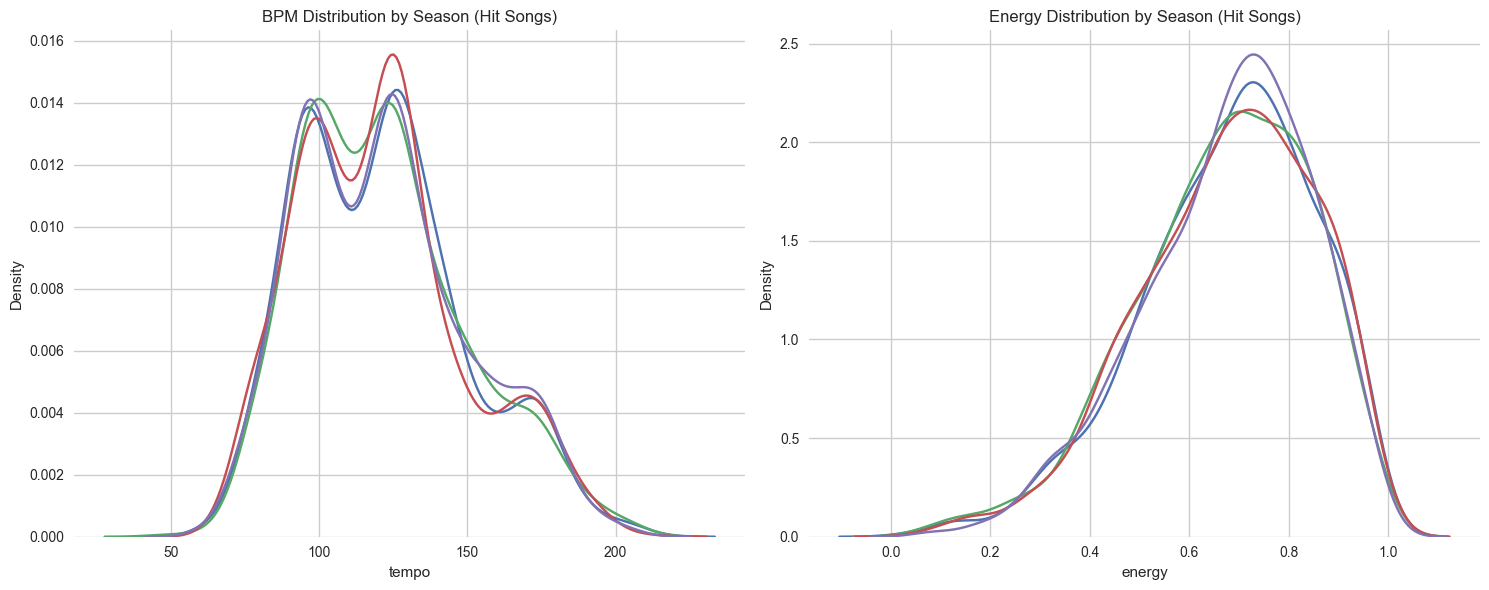

In [5]:
# Analyze seasonal patterns for hits
hit_songs = df[df['is_hit']]

seasonal_patterns = hit_songs.groupby('season').agg({
    'tempo': ['mean', 'std'],
    'energy': ['mean', 'std'],
    'track_popularity': ['mean', 'count']
}).round(2)

print("Seasonal Patterns in Hit Songs:")
print(seasonal_patterns)

# Plot distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

seasons = ['Winter', 'Spring', 'Summer', 'Fall']
for season in seasons:
    season_hits = hit_songs[hit_songs['season'] == season]
    
    # BPM Distribution
    sns.kdeplot(data=season_hits, x='tempo', ax=ax1, label=season)
    
    # Energy Distribution
    sns.kdeplot(data=season_hits, x='energy', ax=ax2, label=season)

ax1.set_title('BPM Distribution by Season (Hit Songs)')
ax2.set_title('Energy Distribution by Season (Hit Songs)')
plt.tight_layout()
plt.show()

## 2. Genre Seasonality

Genres that Perform Best by Season:

WINTER:
                        genre  season     lift  hit_rate  avg_bpm  avg_energy
12                    hip hop  Winter  1.85750     0.369  117.414       0.583
72               classic rock  Winter  1.82850     0.337  120.212       0.676
68                   big room  Winter  0.46325     0.062  127.269       0.849
84  progressive electro house  Winter  0.17400     0.050  125.721       0.804
32            indie poptimism  Winter  0.00400     0.193  117.925       0.605

SPRING:
              genre  season     lift  hit_rate  avg_bpm  avg_energy
61          pop edm  Spring  3.63100     0.256  126.592       0.754
29        latin pop  Spring  3.59150     0.500  118.599       0.708
25          hip pop  Spring  3.52425     0.519  119.978       0.613
9         dance pop  Spring  2.14100     0.516  119.667       0.740
33  indie poptimism  Spring  1.58000     0.296  119.211       0.644

SUMMER:
                 genre  season     lift  hit_rate  avg_bpm  a

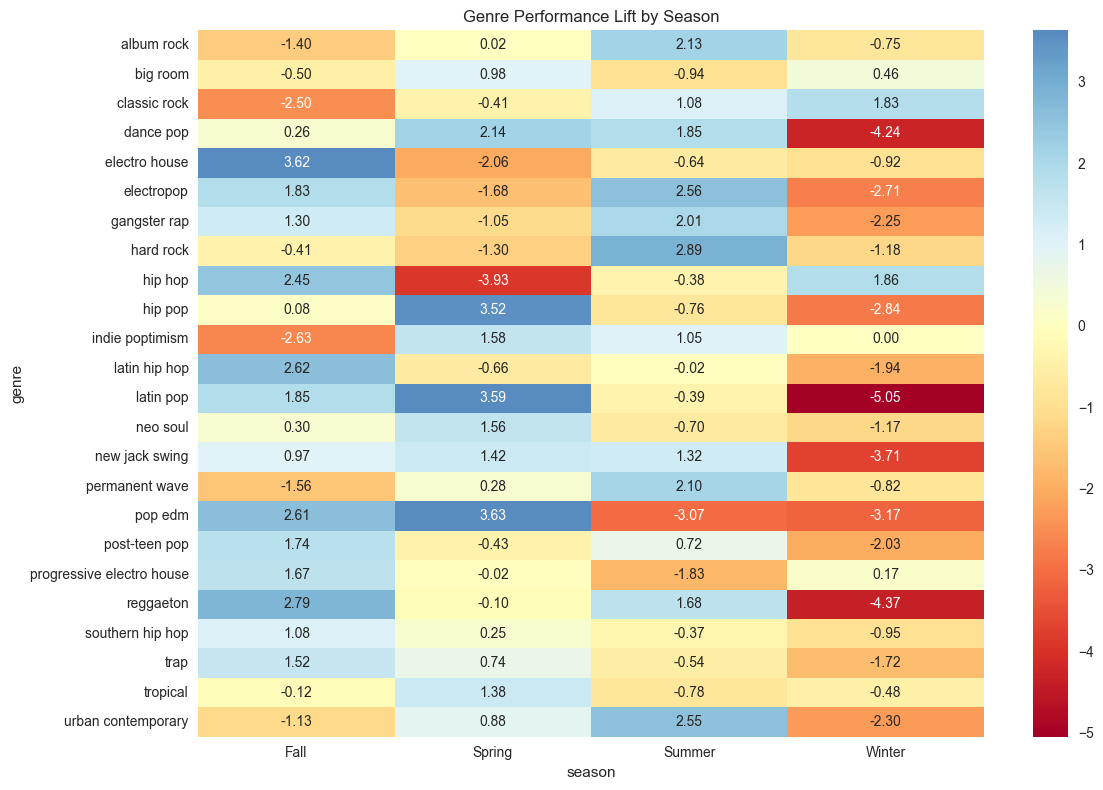

In [6]:
# Analyze genre success by season
genre_season_success = df.groupby(['playlist_subgenre', 'season']).agg({
    'is_hit': 'mean',
    'track_popularity': 'mean',
    'tempo': 'mean',
    'energy': 'mean',
    'track_name': 'count'
}).round(3)

# Find genres that perform better in specific seasons
genre_seasonal_lift = []
for genre in df['playlist_subgenre'].unique():
    genre_data = genre_season_success.loc[genre]
    if len(genre_data) < 4:  # Skip genres without data in all seasons
        continue
        
    genre_avg = genre_data['track_popularity'].mean()
    for season in seasons:
        if season in genre_data.index:
            seasonal_lift = genre_data.loc[season, 'track_popularity'] - genre_avg
            genre_seasonal_lift.append({
                'genre': genre,
                'season': season,
                'lift': seasonal_lift,
                'hit_rate': genre_data.loc[season, 'is_hit'],
                'avg_bpm': genre_data.loc[season, 'tempo'],
                'avg_energy': genre_data.loc[season, 'energy']
            })

seasonal_lift_df = pd.DataFrame(genre_seasonal_lift)

# Show top seasonal performers
print("Genres that Perform Best by Season:")
for season in seasons:
    print(f"\n{season.upper()}:")
    season_data = seasonal_lift_df[seasonal_lift_df['season'] == season].sort_values('lift', ascending=False)
    print(season_data.head().to_string())

# Plot heatmap of genre performance by season
plt.figure(figsize=(12, 8))
heatmap_data = seasonal_lift_df.pivot(index='genre', columns='season', values='lift')
sns.heatmap(heatmap_data, cmap='RdYlBu', center=0, annot=True, fmt='.2f')
plt.title('Genre Performance Lift by Season')
plt.tight_layout()
plt.show()

## 3. Artist Seasonal Performance

Artists Who Significantly Outperform in Specific Seasons:

WINTER OUTPERFORMERS:
Artist | Regular Popularity → Seasonal Popularity (Lift) | BPM | Energy
Of Monsters and Men | 32.3 → 60.3 (+28.0) | 108 BPM | 0.69 energy
Anuel AA | 52.8 → 78.7 (+25.8) | 119 BPM | 0.77 energy
David Bowie | 44.7 → 66.8 (+22.0) | 118 BPM | 0.60 energy
OneRepublic | 54.4 → 73.2 (+18.9) | 123 BPM | 0.73 energy
Wisin | 48.2 → 66.7 (+18.4) | 95 BPM | 0.88 energy
Halsey | 60.5 → 78.3 (+17.8) | 116 BPM | 0.60 energy
Steve Miller Band | 36.6 → 52.0 (+15.4) | 101 BPM | 0.61 energy
Miley Cyrus | 55.8 → 70.3 (+14.5) | 121 BPM | 0.73 energy
G-Eazy | 56.9 → 70.6 (+13.7) | 114 BPM | 0.66 energy
Sampha | 41.5 → 55.0 (+13.5) | 132 BPM | 0.39 energy
Ariana Grande | 61.6 → 74.8 (+13.1) | 111 BPM | 0.57 energy
The Black Keys | 55.2 → 68.3 (+13.1) | 131 BPM | 0.72 energy
Raekwon | 38.0 → 51.0 (+13.0) | 88 BPM | 0.83 energy
India.Arie | 36.7 → 49.7 (+13.0) | 127 BPM | 0.50 energy
Lauv | 63.4 → 76.3 (+12.9) | 124 BPM | 0.53 ene

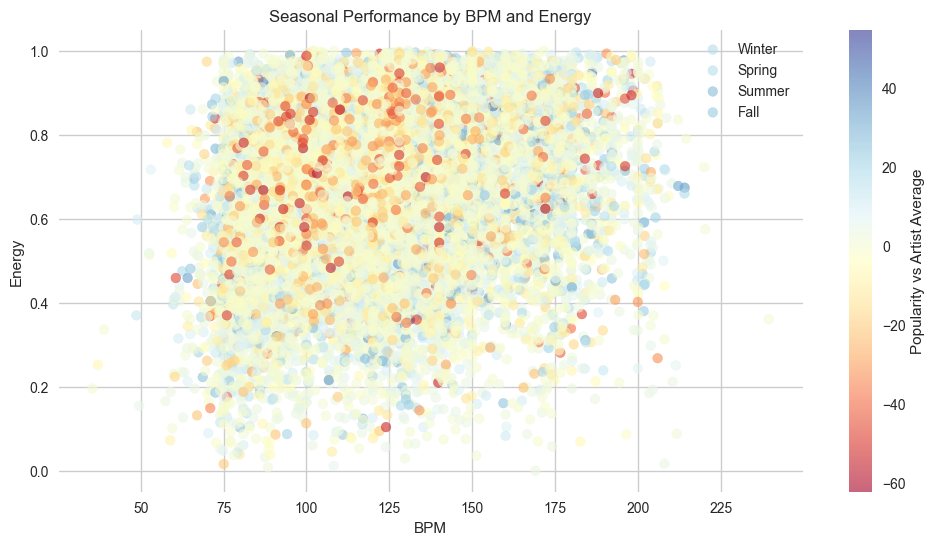

In [9]:
# Find artists who outperform in specific seasons
artist_seasonal = df.groupby(['track_artist', 'season']).agg({
    'track_popularity': 'mean',
    'artist_avg_popularity': 'first',
    'tempo': 'mean',
    'energy': 'mean',
    'track_name': 'count'
}).round(2)

# Calculate seasonal lift
artist_seasonal['popularity_lift'] = artist_seasonal['track_popularity'] - artist_seasonal['artist_avg_popularity']

# Find significant outperformers (at least 3 songs and 10+ point lift)
significant_outperformers = artist_seasonal[
    (artist_seasonal['track_name'] >= 3) &
    (artist_seasonal['popularity_lift'] >= 10)
].sort_values('popularity_lift', ascending=False)

print("Artists Who Significantly Outperform in Specific Seasons:")
for season in seasons:
    print(f"\n{season.upper()} OUTPERFORMERS:")
    # Use boolean indexing instead of loc to safely handle missing seasons
    season_data = significant_outperformers[significant_outperformers.index.get_level_values('season') == season]
    if len(season_data) > 0:
        print("Artist | Regular Popularity → Seasonal Popularity (Lift) | BPM | Energy")
        for idx, row in season_data.iterrows():
            artist = idx[0]
            print(f"{artist} | {row['artist_avg_popularity']:.1f} → {row['track_popularity']:.1f} "
                  f"(+{row['popularity_lift']:.1f}) | {row['tempo']:.0f} BPM | {row['energy']:.2f} energy")

# Plot seasonal performance patterns
plt.figure(figsize=(12, 6))
for season in seasons:
    season_data = df[df['season'] == season]
    plt.scatter(season_data['tempo'], season_data['energy'],
                c=season_data['popularity_vs_avg'], cmap='RdYlBu',
                alpha=0.6, label=season)

plt.colorbar(label='Popularity vs Artist Average')
plt.title('Seasonal Performance by BPM and Energy')
plt.xlabel('BPM')
plt.ylabel('Energy')
plt.legend()
plt.show()

## 4. Success Recipe by Season

In [11]:
# Calculate success recipes for each season
print("Seasonal Hit Song Recipes:")
for season in seasons:
    season_hits = df[(df['season'] == season) & df['is_hit']]
    
    print(f"\n{season.upper()} HITS:")
    print(f"Number of Hits: {len(season_hits)}")
    print(f"BPM: {season_hits['tempo'].mean():.0f} ± {season_hits['tempo'].std():.0f}")
    print(f"Energy: {season_hits['energy'].mean():.2f} ± {season_hits['energy'].std():.2f}")
    
    # Most successful genre
    top_genre = season_hits['playlist_subgenre'].value_counts().index[0]
    genre_count = season_hits['playlist_subgenre'].value_counts().iloc[0]
    print(f"Top Genre: {top_genre} ({genre_count} hits)")
    
    # Example hits
    print("\nExample Hit Songs:")
    top_hits = season_hits.sort_values('track_popularity', ascending=False).head(3)
    for _, song in top_hits.iterrows():
        print(f"\n{song['track_name']} by {song['track_artist']}")
        print(f"Genre: {song['playlist_subgenre']}")
        print(f"Popularity: {song['track_popularity']}")
        print(f"BPM: {song['tempo']:.0f}")
        print(f"Energy: {song['energy']:.2f}")
    print("-" * 80)

Seasonal Hit Song Recipes:

WINTER HITS:
Number of Hits: 1663
BPM: 122 ± 28
Energy: 0.68 ± 0.18
Top Genre: post-teen pop (175 hits)

Example Hit Songs:

The Box by Roddy Ricch
Genre: hip hop
Popularity: 98
BPM: 117
Energy: 0.59

Yummy by Justin Bieber
Genre: dance pop
Popularity: 95
BPM: 146
Energy: 0.52

My Oh My (feat. DaBaby) by Camila Cabello
Genre: post-teen pop
Popularity: 94
BPM: 105
Energy: 0.49
--------------------------------------------------------------------------------

SPRING HITS:
Number of Hits: 1058
BPM: 122 ± 28
Energy: 0.67 ± 0.18
Top Genre: dance pop (113 hits)

Example Hit Songs:

bad guy by Billie Eilish
Genre: dance pop
Popularity: 95
BPM: 135
Energy: 0.42

Someone You Loved by Lewis Capaldi
Genre: dance pop
Popularity: 94
BPM: 110
Energy: 0.41

No Idea by Don Toliver
Genre: hip hop
Popularity: 92
BPM: 128
Energy: 0.61
--------------------------------------------------------------------------------

SUMMER HITS:
Number of Hits: 1174
BPM: 121 ± 28
Energy: 0.68 ± 